In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')
# --------------------------------------------------

# --------------------------------------------------
# load datasets
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # pd.get_dummies()
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# models/estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# models : boost
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# --------------------------------------------------

# **************************************************

# --------------------------------------------------
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)
 
    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols
# nan_cols = check_nan(df)
# --------------------------------------------------

# --------------------------------------------------
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict
# my_detect_outliers(X_train, 'Insulin')
# --------------------------------------------------

# --------------------------------------------------
def encode(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
# object_cols = encode(df)
# --------------------------------------------------

# --------------------------------------------------
def mapping(df, col):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df[col] = df[col].map(dict)
    return df[col].value_counts()
# mapping(df, 'gender')
# --------------------------------------------------

# --------------------------------------------------
def split_xy(df, target, test_size=0.2):
    
    """split X, y & train, test"""
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')
# --------------------------------------------------

# --------------------------------------------------
def scores(y_test, y_pred):
    
    """evaluation scores"""
    
    f1        = f1_score         (y_test, y_pred)
    accuracy  = accuracy_score   (y_test, y_pred)
    precision = precision_score  (y_test, y_pred)
    recall    = recall_score     (y_test, y_pred)
    c_matrix  = confusion_matrix (y_test, y_pred)
    
    print('-' * 45)
    print(
          f'accuracy  = {accuracy:.6f},  '
          f'f1 score  = {f1:.6f},  \n'
          f'precision = {precision:.6f},  '
          f'recall    = {recall:.6f},')
    
    plt.figure(figsize=(3, 2))
    plt.title('confusion matrix')
    plt.xlabel('Predict')
    plt.ylabel('Actual')
    sns.heatmap(c_matrix, annot=True, linewidths=1, cmap='Blues', annot_kws={"size": 14})
    plt.show()
# --------------------------------------------------

# --------------------------------------------------
def curves(y_test, probas_pred):
        
    FPRS, TPRS, thresholds = roc_curve(y_test, probas_pred[:, 1])
 
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
 
    # settings
    plt.subplot(121)
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')
 
    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')
    plt.legend()
 
    precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
 
    plt.subplot(122)
    plt.title('precision recall curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('scores')
 
    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.legend()
 
    plt.show()
    
    print('AUC = ', roc_auc_score(y_test, probas_pred[:, 1]))
# --------------------------------------------------
# --------------------------------------------------

# encoder

In [2]:
# array-like ; array, list, df, matrix, iterables
# overriding ; 부모 클래스의 기능을 상속받는 것
# 부모 것을 약간 수정/개조해서 사용

LabelEncoder()

# le.fit(X)
# input arr-like shape (n_samples,)
# return self

# le.fit_transform(X), le.transform(X)
# input  arr-like shape (n_samples,)
# return arr-like shape (n_samples,)

LabelEncoder()

In [3]:
# onehotencoder ; return matrix이기 때문에 .get_dummies() 사용

In [4]:
# pd.get_dummies()
# 등급 유지를 하지 않아도 될 때 사용
# 등급 유지를 해야 한다면, 순서를 인식할 수 있도록 get_dummies 금지

emp = {"empno":[7733,7652,7799, 9999], "ename":['SMITH','KING','ALLEN', np.nan], "deptno":[10,20,30, np.nan]}
emp_df = pd.DataFrame(emp)
emp_df

,empno,ename,deptno
0,7733,SMITH,10.0
1,7652,KING,20.0
2,7799,ALLEN,30.0
3,9999,NaN,NaN


In [5]:
# pd.get_dummies(data, columns=[])
emp_df = pd.get_dummies(emp_df, columns=['ename']); emp_df

,empno,deptno,ename_ALLEN,ename_KING,ename_SMITH
0,7733,10.0,0,0,1
1,7652,20.0,0,1,0
2,7799,30.0,1,0,0
3,9999,NaN,0,0,0


# scale

In [6]:
# MinMaxScaler
ms = MinMaxScaler()

# X_train_set ; fit, transform
# X_test_set  ; transform

# ms.fit(X)
# input arr-like shape(n_samples, n_features)
# return self

# ms.transform(X)
# input arr-like shape(n_samples, n_features)
# return arr shape(n_samples, n_features)

In [7]:
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# outlier

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcAqc6V%2FbtqyQLiddUd%2FiXQVu1nYTo2rx3Q8xZBqy0%2Fimg.png" width=800 height=400>

In [8]:
df = pd.read_csv('./kaggle/pima/diabetes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')

In [10]:
X_train[['Insulin', 'Age']].describe()

,Insulin,Age
count,614.000000,614.000000
mean,74.802932,33.558632
std,113.488716,11.884531
min,0.000000,21.000000
25%,0.000000,24.000000
50%,0.000000,30.000000
75%,122.000000,41.000000
max,846.000000,81.000000


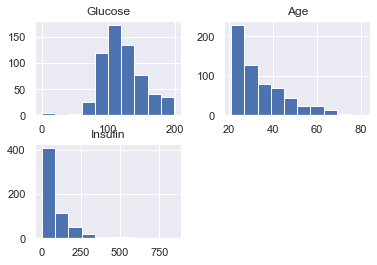

In [11]:
X_train[['Glucose', 'Age', 'Insulin']].hist()
plt.show()

In [12]:
# outlier 제거는 train_set에만
# df 전체를 대상으로 outlier 제거를 하면 train_set 줄어들어서 학습에 악영향
# 현업에서는 outlier 제거는 조심해서 함, 나중에 어느 데이터가 들어올지 모르기 때문
# 공모전에서는 학습만 잘 시키면 되기 때문에, 선별

check_outliers(X_train, ['Insulin', 'Glucose','Age'], 1.8)

{'Insulin': Int64Index([258, 715, 645, 415, 486,  13, 186, 286, 248, 111, 695, 584, 753,
             231, 296, 409, 655, 370, 220, 228],
            dtype='int64'),
 'Glucose': Int64Index([182, 349, 342, 75, 502], dtype='int64'),
 'Age': Int64Index([453, 459], dtype='int64')}

# corr heatmap

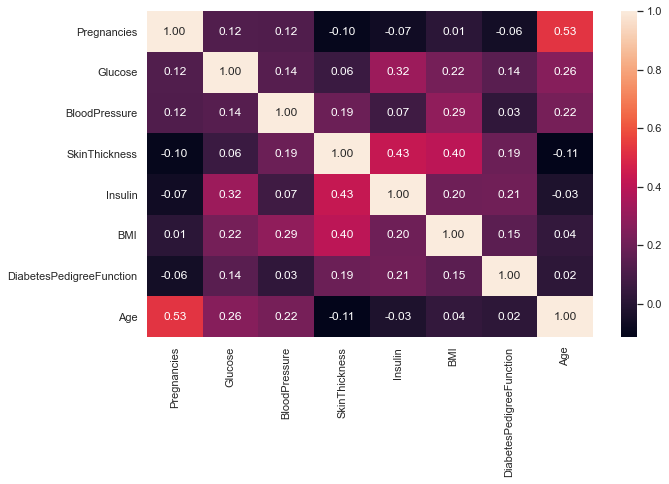

In [13]:
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(X_train.corr(), fmt='.2f', annot=True); plt.show()

In [14]:
X_train[['Glucose', 'Insulin']].describe()

,Glucose,Insulin
count,614.000000,614.000000
mean,120.679153,74.802932
std,31.913878,113.488716
min,0.000000,0.000000
25%,100.000000,0.000000
50%,117.000000,0.000000
75%,139.750000,122.000000
max,199.000000,846.000000


# outlier plots

<AxesSubplot:xlabel='Glucose'>

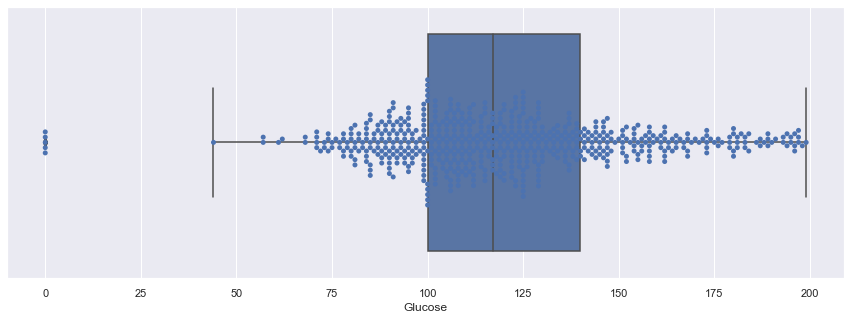

In [15]:
f, ax =plt.subplots(figsize=(15, 5))
sns.boxplot(x=X_train['Glucose'])
sns.swarmplot(x=X_train['Glucose'])

In [16]:
# Glucose outliers
Glucose_idx = X_train[X_train['Glucose'] < 20]['Glucose'].index.values; Glucose_idx

array([182, 349, 342,  75, 502], dtype=int64)

<AxesSubplot:xlabel='Insulin'>

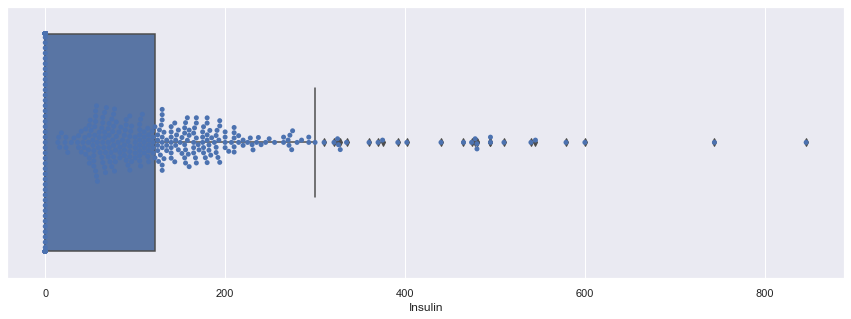

In [17]:
f, ax =plt.subplots(figsize=(15, 5))
sns.boxplot(x=X_train['Insulin'])
sns.swarmplot(x=X_train['Insulin'])

In [18]:
# Insulin outliers
Insulin_idx = X_train[X_train['Insulin'] > 620]['Insulin'].index.values; Insulin_idx

array([ 13, 228], dtype=int64)

<AxesSubplot:xlabel='Age'>

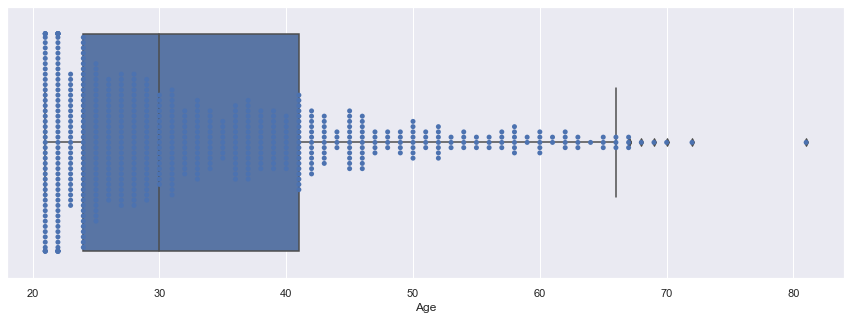

In [19]:
# Age outliers
f, ax =plt.subplots(figsize=(15, 5))
sns.boxplot(x=X_train['Age'])
sns.swarmplot(x=X_train['Age'])

In [20]:
Age_idx = X_train[X_train['Age'] > 80]['Age'].index.values; Age_idx

array([459], dtype=int64)

In [21]:
# drop outliers
idxs = [Glucose_idx, Insulin_idx, Age_idx]

for idx in idxs:
    df.drop(index=idx, inplace=True)

In [22]:
# 코드 정리 순서
# 1. 데이터 로드 / 점수 / 공통함수
# 2. zero fill
# 3. corr heatmap
# 4. drop outliers
# 5. scaling
# 6. model change

X, y = split_xy(df, 'Outcome')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probas_pred = model.predict_proba(X_test)

scores(y_test, y_pred)
curves(y_test, probas_pred)

In [23]:
X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')

---------------------------------------------
accuracy  = 0.776316,  f1 score  = 0.660000,  
precision = 0.702128,  recall    = 0.622642,


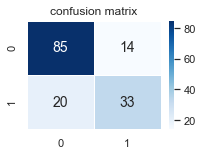

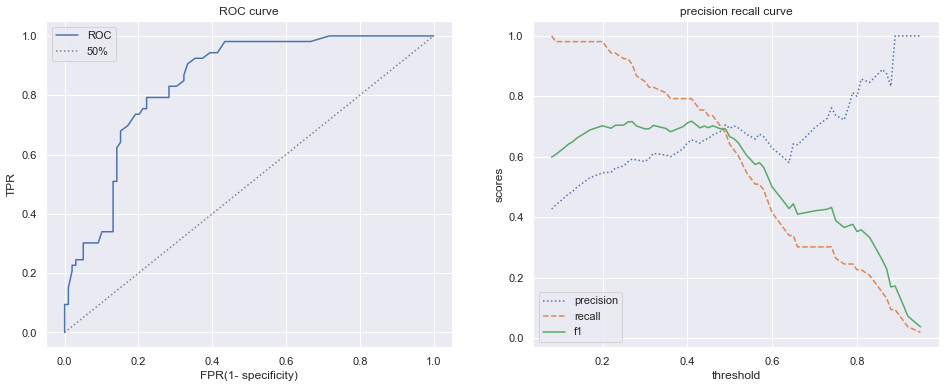

AUC =  0.844291976367448


In [24]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probas_pred = model.predict_proba(X_test)

scores(y_test, y_pred)
curves(y_test, probas_pred)

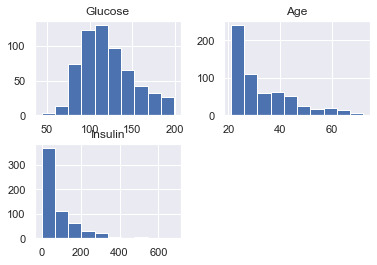

In [25]:
X_train[['Glucose', 'Age', 'Insulin']].hist()
plt.show()

# KFold, StratifiedKFold

---------------------------------------------
accuracy  = 0.736842,  f1 score  = 0.574468,  
precision = 0.658537,  recall    = 0.509434,


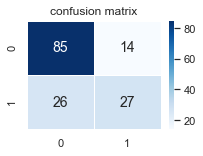

---------------------------------------------
accuracy  = 0.769737,  f1 score  = 0.588235,  
precision = 0.781250,  recall    = 0.471698,


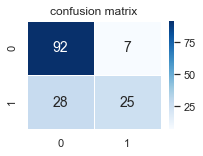

---------------------------------------------
accuracy  = 0.822368,  f1 score  = 0.721649,  
precision = 0.795455,  recall    = 0.660377,


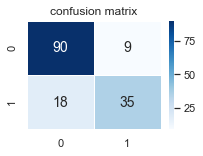

---------------------------------------------
accuracy  = 0.776316,  f1 score  = 0.630435,  
precision = 0.743590,  recall    = 0.547170,


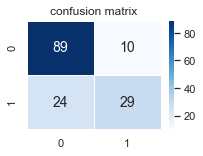

---------------------------------------------
accuracy  = 0.769737,  f1 score  = 0.700855,  
precision = 0.640625,  recall    = 0.773585,


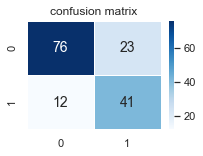

f1  0.6431284694447019
acc 0.775
pre 0.7238911748820286
rec 0.5924528301886792


In [39]:

X = df.drop('Outcome', axis=1)
y = df['Outcome']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
model = RandomForestClassifier(random_state=0)

t_f1  = []
t_acc = []
t_pre = []
t_rec = []

for train_idx, test_idx in skf.split(X, y):
    skX_train, skX_test = X.iloc[train_idx], X.iloc[test_idx]
    sky_train, sky_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(skX_train, sky_train)
    y_pred = model.predict(skX_test)
    probas_pred = model.predict_proba(skX_test)
    
    f1        = f1_score         (sky_test, y_pred)
    accuracy  = accuracy_score   (sky_test, y_pred)
    precision = precision_score  (sky_test, y_pred)
    recall    = recall_score     (sky_test, y_pred)
    
    t_f1.append(f1)
    t_acc.append(accuracy)
    t_pre.append(precision)
    t_rec.append(recall)
    
    scores(sky_test, y_pred)
print('f1 ', np.array(t_f1).mean())
print('acc', np.array(t_acc).mean())
print('pre', np.array(t_pre).mean())
print('rec', np.array(t_rec).mean())

In [59]:
# arr concat
arr1 = np.array([[1, 2, 3], [11, 22, 33]])
arr2 = np.array([4, 5])

s1 = pd.Series([arr1])
s2 = pd.Series([arr2])

a = np.concatenate([s1, s2])
a.shape

(2,)

In [62]:
# cross val score

In [63]:
# !pip install catboost

You should consider upgrading via the 'C:\AI\pythonProject\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [64]:
# !pip install lightgbm

You should consider upgrading via the 'C:\AI\pythonProject\venv\Scripts\python.exe -m pip install --upgrade pip' command.
